In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import src.models
import src.spectrograms as spec
import src.utils as utils
import src.init as init

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
else:
    dev = "cpu"

In [3]:
file_name  = "example-1"
audio_file = f"synth-dataset/audios/{file_name}.wav"
midi_file  = f"synth-dataset/midis/{file_name}.mid"
waveform, sample_rate = torchaudio.load(audio_file)

# Convert to mono if stereo
# if waveform.shape[0] > 1:
#     waveform = waveform.mean(dim=0, keepdim=True)
#     waveform = waveform.squeeze(0)

## Getting the spectrogram

### STFT Spectrogram

In [4]:
n_fft           = 1024
hop_length      = 512
min_mag         = 1e-5

spec_stft, spec_np, times_stft, freq_stft = spec.stft_spec(waveform, sample_rate, n_fft, hop_length, min_mag)

RuntimeError: stft input and window must be on the same device but got self on cpu and window on cuda:0

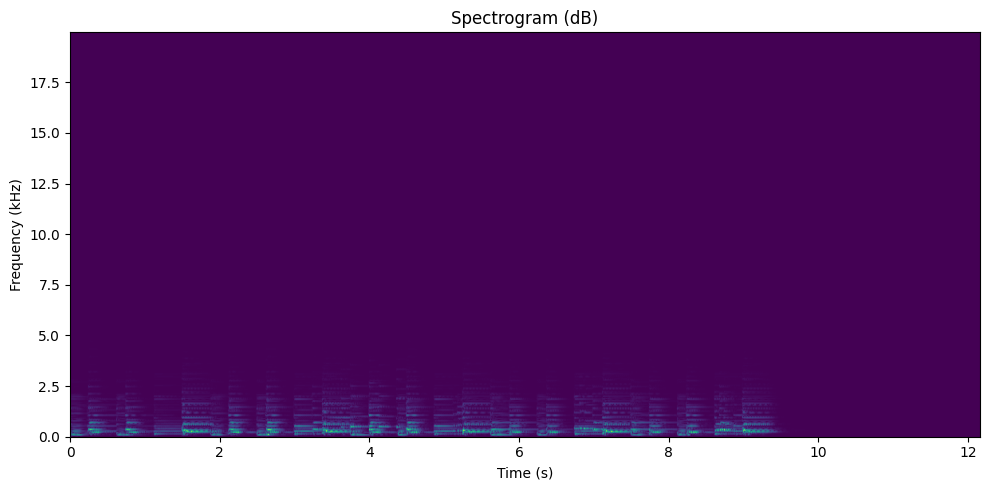

In [ ]:
min_freq = 0
max_freq = 20*1e3

spec.vis_spectrogram(spec_stft, times_stft, freq_stft, 0, times_stft[-1], min_freq, max_freq)

Folding over in the 22-25 kHz range due to the sample rate (48kHz)

$\to$ Applying a lowpass filter to attenuate it (attenuate everything over $\frac{sample\_rate}{2}$)

In [ ]:
# cutoff_freq = 21000
# nyquist_rate = sample_rate / 2
# normalized_cutoff = cutoff_freq / nyquist_rate
# order = 4
# b, a = scipy.signal.butter(order, normalized_cutoff, btype='low')
# filtered_waveform = torch.tensor(scipy.signal.lfilter(b, a, waveform.numpy(), axis=-1))

# filtered_spec, filtered_spec_np, times, frequencies = spec.stft_spec(filtered_waveform, sample_rate, n_fft, hop_length, min_mag)
# spec.vis_spectrogram(filtered_spec_np, times, frequencies, 0, times_stft[-1], min_freq, max_freq)

### CQT Spectrogram

In [5]:
n_fft           = 1024
hop_length      = 128

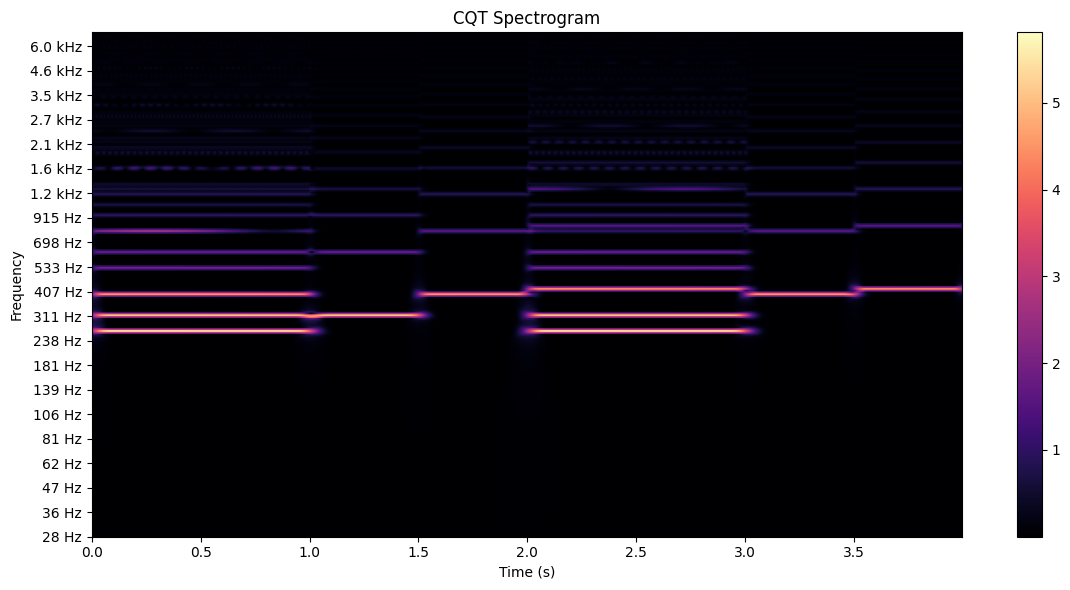

In [9]:
spec_cqt, times_cqt, freq_cqt = spec.cqt_spec(waveform, sample_rate, hop_length)
spec.vis_cqt_spectrogram(spec_cqt, times_cqt, freq_cqt, 0, times_cqt[-1])

### ERB Spectrogram

In [8]:
# spec_erb, times_erb, freqs_erb = spec.erb_spec(waveform, sample_rate, hop_length=hop_length)
# spec.vis_erb_spectrogram(spec_erb, freqs_erb, times, start=0, stop=times[-1])

### GroundTruth midi file

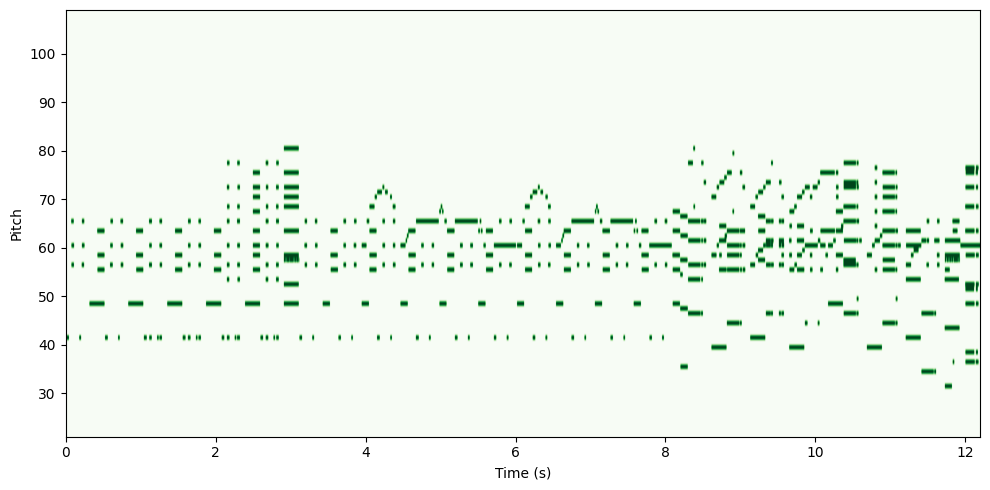

In [9]:
midi_path           = "test-data/take-five.mid"
midi, times_midi    = spec.midi_to_pianoroll(midi_path, waveform, times_cqt, hop_length, sample_rate)
spec.vis_midi(midi, times_midi, 0, times_midi[-1])

## Unrolled NMF

M ≈ WH 

**M** : CQT spectrogram (`spec_cqt`), **W** : dictionnary of notes, **H** : notes activations, **l** : number of different notes to detect

In [10]:
# Init
M           = spec_cqt
n_sources   = 1
l           = n_sources*88
f           = M.shape[0]
t           = M.shape[1]
n_iter      = 5

In [11]:
print(f"input spectrogram: {M.shape}")
print(f"number of notes to be split: {l}")
print(f"number of frequency bins: {f}")
print(f"number of time bins: {t}")

input spectrogram: torch.Size([288, 4575])
number of notes to be split: 88
number of frequency bins: 288
number of time bins: 4575


### Iterative MU
Requires pretrained Aw and Ah

In [12]:
W, H, M_hat = src.models.MU_iter(M, l, f, t, n_iter)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/models.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M)


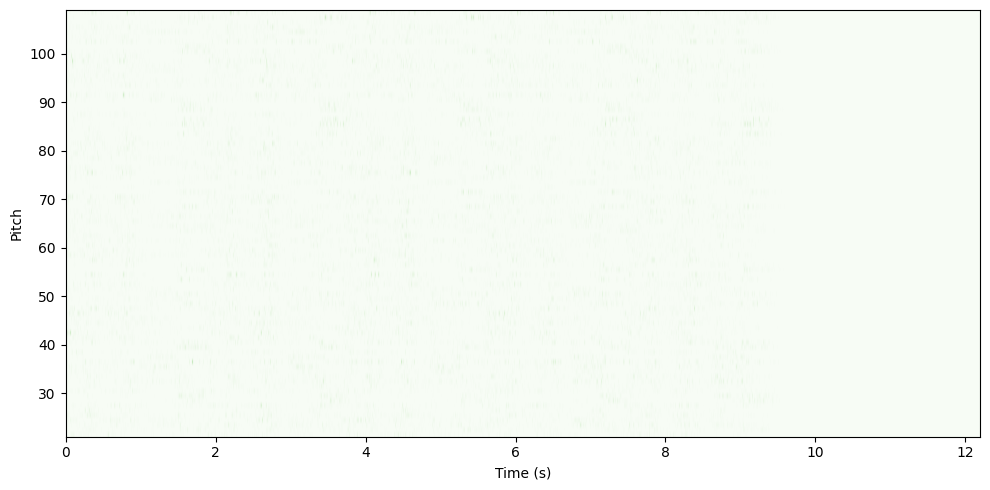

In [13]:
spec.vis_midi(H[-1,:,:].detach().numpy(), times_cqt, times_cqt[0], times_cqt[-1])

### Unrolled RALMU

- **Init** W and H

In [14]:
single_note = "test-data/single-notes"
# W, freqs = init.init_W(single_note)
# H = init.init_H(l, t, W, M, n_init_steps=100, beta=2)
# pitches, notes, W, H = init.W_to_pitch(W, freqs, H=H)

In [15]:
eps     = 1e-5
# model   = src.models.RALMU(f, t, l=l, eps=eps, n_iter=n_iter, shared=True)
model = src.models.RALMU2(l, eps, beta=1, W_path=single_note, n_iter=n_iter, shared=True)
device  = torch.device('cpu')
model.to(device=device)

RALMU2(
  (layers): ModuleList(
    (0-4): 5 x RALMU_block2(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (relu): ReLU()
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
    )
  )
)

In [16]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

13250

- **Load** the dataset

In [17]:
dataset = src.utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=True)

- **Train** the model

In [18]:
n_epochs    = 2
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-2)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


W init length: 5.849658250808716, H init length: 0.2890160083770752
Initialized W and H from files
Cached W and H


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


Grad norm: 9.331281762570143e-05
Grad norm: 8.721475023776293e-05
Grad norm: 0.0007504731183871627
Grad norm: 0.00016551664157304913
Grad norm: 0.0004155609058216214
Grad norm: 2.31724834520719e-06
Grad norm: 0.0002969983615912497
Grad norm: 9.656099427957088e-05
Grad norm: 0.0015640654601156712
Grad norm: 0.00017654385010246187
Grad norm: 0.0007795309065841138
Grad norm: 1.0405011380498763e-05
W init length: 6.443456172943115, H init length: 0.052160024642944336
Initialized W and H from files
Cached W and H
Grad norm: 0.0006967195076867938
Grad norm: 0.00395439425483346
Grad norm: 0.018968647345900536
Grad norm: 0.005735510028898716
Grad norm: 0.0150522505864501
Grad norm: 0.012104997411370277
Grad norm: 0.011849894188344479
Grad norm: 0.005651242099702358
Grad norm: 0.03825721517205238
Grad norm: 0.00898214802145958
Grad norm: 0.029143745079636574
Grad norm: 0.022104736417531967
============= Epoch 1, Loss: 26.962892532348633 =============
Retrieved cached W and H
Grad norm: 0.000741

Text(0.5, 0, 'Epochs')

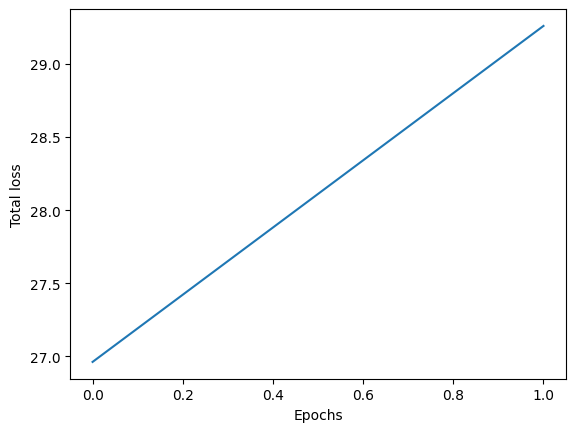

In [19]:
criterion = nn.BCELoss()
loss = src.utils.train(n_epochs, model, optimizer, loader, device, criterion)

plt.plot(loss)
plt.ylabel("Total loss")
plt.xlabel("Epochs")

In [ ]:
W_hat, H_hat, M_hat, midi_hat, active_midi = utils.transribe(model, spec_cqt, device)

Retrieved cached W and H


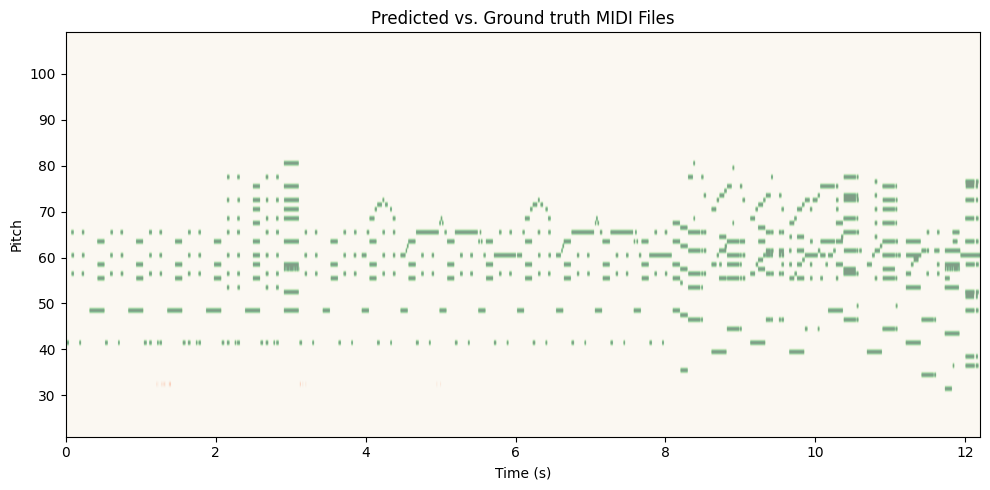

In [21]:
# fig, ax = plt.subplots()
# cax1 = ax.imshow(midi, cmap='Blues', alpha=0.5, aspect="auto")
# cax2 = ax.imshow(midi_hat, cmap='Reds', alpha=0.5, aspect="auto")
# fig.colorbar(cax1, ax=ax, label='Matrix 1')
# fig.colorbar(cax2, ax=ax, label='Matrix 2')
# plt.show()
spec.compare_midi(midi, midi_hat, times_cqt, 0, times_cqt[-1])

In [22]:
gt = midi.sum()
hat = midi_hat.sum()

In [28]:
gt

tensor(13169.)